In [1]:
from local_vars import root_folder

data_folder = r"Circles"
image_size = 64
batch_size = 20
input_intensity_scaling = 1 / 255.0

In [2]:
import pandas as pd
import numpy as np
import itertools
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from skimage.io import imread
from skimage.transform import resize

In [3]:
from tensorflow.keras.utils import Sequence

In [5]:
data_fullpath = os.path.join(root_folder, data_folder)
train_fullpath = os.path.join(data_fullpath, "train")
valid_fullpath = os.path.join(data_fullpath, "valid")
test_fullpath = os.path.join(data_fullpath, "test")

print("Training data folder:   {}".format(train_fullpath))
print("Validation data folder: {}".format(valid_fullpath))
print("Test data folder:       {}".format(test_fullpath))

Training data folder:   d:\Data\Circles\train
Validation data folder: d:\Data\Circles\valid
Test data folder:       d:\Data\Circles\test


In [6]:
train_annotations_df = pd.DataFrame()

num_csv_files = 0
for file_name in os.listdir(train_fullpath):
    if not file_name.endswith(".csv"):
        continue
    num_csv_files += 1
    current_file_path = os.path.join(train_fullpath, file_name)
    train_annotations_df = pd.concat([train_annotations_df, pd.read_csv(current_file_path)])

valid_annotations_df = pd.DataFrame()

for file_name in os.listdir(valid_fullpath):
    if not file_name.endswith(".csv"):
        continue
    num_csv_files += 1
    current_file_path = os.path.join(valid_fullpath, file_name)
    valid_annotations_df = pd.concat([valid_annotations_df, pd.read_csv(current_file_path)])

test_annotations_df = pd.DataFrame()

for file_name in os.listdir(test_fullpath):
    if not file_name.endswith(".csv"):
        continue
    num_csv_files += 1
    current_file_path = os.path.join(test_fullpath, file_name)
    test_annotations_df = pd.concat([test_annotations_df, pd.read_csv(current_file_path)])

num_test_images = test_annotations_df.shape[0]
    
print("Number of training images:   {}".format(train_annotations_df.shape[0]))
print("Number of validation images: {}".format(valid_annotations_df.shape[0]))
print("Number of test images:       {}".format(num_test_images))

Number of training images:   5000
Number of validation images: 200
Number of test images:       200


In [7]:
annot_data = train_annotations_df[:5]
print("Original annotations")
print(annot_data)

scaled_positions = pd.concat( [annot_data['x'] / annot_data['width'], annot_data['y'] / annot_data['height']], axis=1 )
scaled_positions.columns = ['x', 'y']

# scaled_positions = np.concatenate( annot_data[:,2] / annot_data[:,0], annot_data[:,3] / annot_data[:,1], axis=1)
print("\nScaled positions")
print(scaled_positions)

Original annotations
   Unnamed: 0   filename  width  height  class    x    y
0           0  00000.png    128     128      1   12   63
1           1  00001.png    128     128      1   59   62
2           2  00002.png    128     128      1   88   37
3           3  00003.png    128     128      1  120  113
4           4  00004.png    128     128      1  110   88

Scaled positions
          x         y
0  0.093750  0.492188
1  0.460938  0.484375
2  0.687500  0.289062
3  0.937500  0.882812
4  0.859375  0.687500


In [8]:
class MyBatchGenerator(Sequence):
    
    def __init__(self, image_filenames, annotations_df, batch_size, image_size=256):
        self.image_filenames, self.annotations_df = image_filenames, annotations_df
        self.batch_size = batch_size
    
    def __len__(self):
        num_batches = np.ceil(len(self.image_filenames) / float(self.batch_size))
        return int(num_batches)
    
    def __getitem__(self, idx):
        from_index = idx * self.batch_size
        to_index = (idx + 1) * self.batch_size
        batch_x = self.image_filenames[from_index:to_index]
        annot_data = self.annotations_df[['width', 'height', 'x', 'y']].iloc[from_index:to_index]
        batch_y = pd.concat( [annot_data['x'] / annot_data['width'], annot_data['y'] / annot_data['height']], axis=1 )
        return np.array([
            resize(
                imread(file_name) * input_intensity_scaling,
                (image_size, image_size, 1),
                anti_aliasing=False,
                preserve_range=True,
                mode='constant') for file_name in batch_x]),  np.array(batch_y)

In [9]:
train_image_filenames = [os.path.join(train_fullpath,fn) for fn in os.listdir(train_fullpath) if fn.endswith('png')]
valid_image_filenames = [os.path.join(valid_fullpath,fn) for fn in os.listdir(valid_fullpath) if fn.endswith('png')]
test_image_filenames = [os.path.join(test_fullpath,fn) for fn in os.listdir(test_fullpath) if fn.endswith('png')]

In [10]:
train_generator = MyBatchGenerator(train_image_filenames, train_annotations_df, batch_size, image_size)
valid_generator = MyBatchGenerator(valid_image_filenames, valid_annotations_df, batch_size, image_size)

Example input image with true location

Validation locations
[[0.25      0.2734375]
 [0.0546875 0.3203125]
 [0.484375  0.3359375]
 [0.921875  0.1875   ]
 [0.859375  0.2265625]]


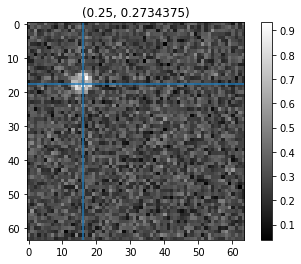

In [11]:
x, y = valid_generator.__getitem__(0)

print("Example input image with true location")
plt.title(str((y[0][0], y[0][1])))
plt.imshow(x[0][:,:,0], cmap='gray')
plt.axvline(x=y[0][0] * image_size)
plt.axhline(y=y[0][1] * image_size)
out = plt.colorbar()

print("\nValidation locations")
print(y[:5])

In [12]:
model = tf.keras.Sequential()

model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(image_size, image_size, 1)))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(.2))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(.2))

model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(.2))

model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(.2))
model.add(layers.Dense(2, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0

In [13]:
num_validation_steps = valid_annotations_df.shape[0] // batch_size
num_steps = train_annotations_df.shape[0] // batch_size

print("Training steps:   {}".format(num_steps))
print("Validation steps: {}".format(num_validation_steps))

Training steps:   250
Validation steps: 10


In [14]:
model.compile(tf.keras.optimizers.SGD(lr=0.1), loss='mse', metrics=['accuracy'])

In [15]:
num_epochs = 8

history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=num_steps,
    epochs=num_epochs,
    verbose=1,
    validation_data=valid_generator,
    validation_steps=num_validation_steps)

Epoch 1/8
250/250 [==============================] - 12s 50ms/step - loss: 0.0685 - accuracy: 0.4988 - val_loss: 0.0700 - val_accuracy: 0.4600
Epoch 2/8
250/250 [==============================] - 12s 48ms/step - loss: 0.0683 - accuracy: 0.5150 - val_loss: 0.0702 - val_accuracy: 0.4600
Epoch 3/8
250/250 [==============================] - 12s 47ms/step - loss: 0.0681 - accuracy: 0.5192 - val_loss: 0.0696 - val_accuracy: 0.4600
Epoch 4/8
250/250 [==============================] - 12s 46ms/step - loss: 0.0637 - accuracy: 0.7248 - val_loss: 0.0355 - val_accuracy: 0.9250
Epoch 5/8
250/250 [==============================] - 13s 51ms/step - loss: 0.0112 - accuracy: 0.9548 - val_loss: 0.0067 - val_accuracy: 0.9850
Epoch 6/8
250/250 [==============================] - 12s 48ms/step - loss: 0.0062 - accuracy: 0.9574 - val_loss: 0.0043 - val_accuracy: 0.9850
Epoch 7/8
250/250 [==============================] - 11s 45ms/step - loss: 0.0050 - accuracy: 0.9594 - val_loss: 0.0037 - val_accuracy: 0.9850

Text(0.5, 1.0, 'Accuracy Curves')

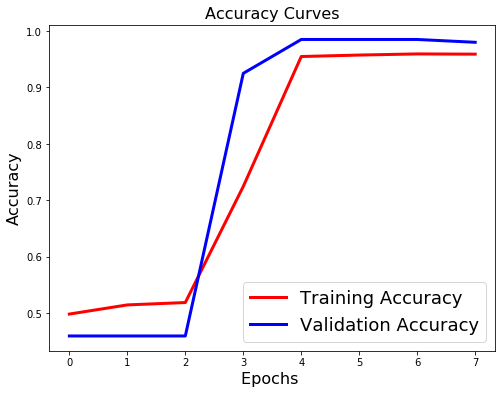

In [17]:
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [18]:
test_generator = MyBatchGenerator(test_image_filenames, test_annotations_df, num_test_images, image_size)

In [19]:
def plots(ims, ys, figsize=(20,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis("Off")
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i][:, :, 0], cmap='gray')
        plt.axvline(x=ys[i][0] * image_size)
        plt.axhline(y=ys[i][1] * image_size)

In [20]:
x, y = test_generator.__getitem__(0)
y_pred = model.predict(x)

n = len(y)
average_error = 0.0
averaging_factor = 1.0 / n
for i in range(len(y)):
    distance = np.linalg.norm(y[i] - y_pred[i])
    average_error += distance * averaging_factor

print("Average error: {0:.4f}".format(average_error))    

print("\nTrue locations")
print(y[:5])

print("\nPredicted locations")
print(y_pred[:5])

Average error: 0.0689

True locations
[[0.5234375 0.421875 ]
 [0.7421875 0.7265625]
 [0.234375  0.6796875]
 [0.1875    0.734375 ]
 [0.796875  0.109375 ]]

Predicted locations
[[0.51787996 0.43836552]
 [0.67328846 0.6562232 ]
 [0.1800656  0.6816504 ]
 [0.0947547  0.8033882 ]
 [0.7043417  0.22132918]]


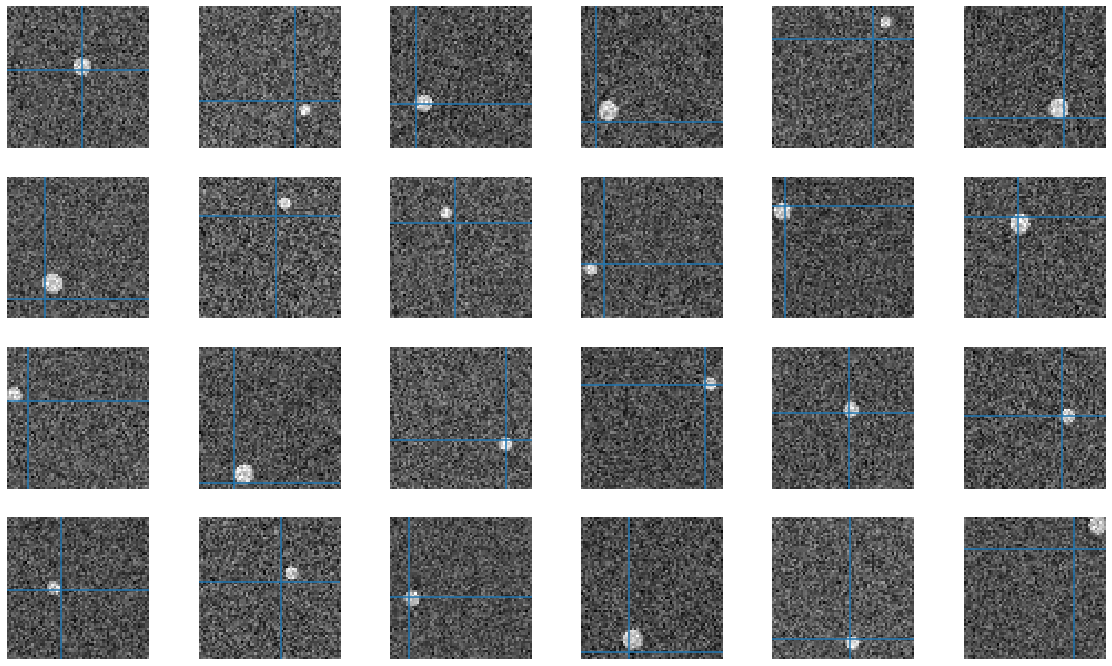

In [21]:
plots(x[:24], y_pred[:24], figsize=(20,12), rows=4)

In [22]:
import datetime

timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

weights_folder = os.path.join(root_folder, "weights")

if not os.path.exists(weights_folder):
    os.makedirs(weights_folder)
    print("Creating folder: {}".format(weights_folder))

weights_file_name = "weights_" + timestamp + ".h5"
weights_file_path = os.path.join(weights_folder, weights_file_name)

model.save_weights(weights_file_path)

Creating folder: d:\Data\weights
